In [380]:
import pickle

import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer, HashingVectorizer
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, PorterStemmer, WordNetLemmatizer
import string

from sklearn.model_selection import train_test_split

from sklearn.decomposition import NMF

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer, MultiLabelBinarizer
from sklearn.decomposition import TruncatedSVD


from sklearn.cluster import MiniBatchKMeans, KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, silhouette_samples
import itertools

import matplotlib.cm as cm

%matplotlib inline

In [434]:
class StemmedCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        stemmer = SnowballStemmer('english')
        analyzer = super().build_analyzer()
        return lambda doc: ([stemmer.stem(w) for w in analyzer(doc) if w.isalpha() and len(w) > 3])
    
class StemmedTfidfVectorizer(TfidfVectorizer):
    def build_analyzer(self):
        stemmer = SnowballStemmer('english')
        analyzer = super().build_analyzer()
        return lambda doc: ([stemmer.stem(w) for w in analyzer(doc) if w.isalpha() and len(w) > 3])
    
class StemmedHashingVectorizer(HashingVectorizer):
    def build_analyzer(self):
        stemmer = SnowballStemmer('english')
        analyzer = super().build_analyzer()
        return lambda doc: ([stemmer.stem(w) for w in analyzer(doc) if w.isalpha()])

scv = StemmedCountVectorizer(strip_accents='unicode',
                            stop_words=set(stopwords.words('english')) | set(string.punctuation) | {'abby', 'year', 'time'},
                             max_df=0.5,
                             min_df=2,
                             ngram_range=(1, 2),
                             max_features=2000)

stv = StemmedTfidfVectorizer(strip_accents='unicode',
                            stop_words=set(stopwords.words('english')) | set(string.punctuation) | {'abby', 'year', 'time'},
                             min_df=2,
                             max_df=0.5,
                             ngram_range=(1, 3),
                             max_features=10000)



## Import Data

In [263]:
qadf = pd.read_csv('../data/dearabby_qa.csv', index_col=0)

In [264]:
new_df = qadf[qadf['categories'].notna()]

In [196]:
# new_df = qadf[]

In [265]:
X = new_df['qa']
y = new_df['categories']


In [435]:
count_df = scv.fit_transform(X)

In [436]:
tfidf_df_train = stv.fit_transform(X)

In [381]:
with open('tfidf_vect.model', 'wb') as vector_model:
    pickle.dump(stv, vector_model)

In [437]:
pca_tv = PCA(n_components=2, random_state=42)
pca_X_tv = pca_tv.fit_transform(tfidf_df_train.toarray())

In [382]:
with open('pca.model', 'wb') as pca_model:
    pickle.dump(pca_tv, pca_model)

In [438]:
pca_cv = PCA(n_components=2, random_state=42)
pca_X_cv = pca_cv.fit_transform(count_df.toarray())

In [101]:
# scatter_plot_points_cv = pca.fit_transform(count_df.toarray())

In [20]:
def make_silhouette_plot(axs, X, n_clusters):

    ax1, ax2 = axs

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=42, n_jobs=-1)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = (
            sample_silhouette_values[cluster_labels == i])

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        cmap = cm.get_cmap("Spectral")
        color = cmap(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhoutte score of all the values
    # ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    # colors = matplotlib.cm.spectral(cluster_labels.astype(float) / n_clusters)
    cmap = cm.get_cmap("Spectral")
    colors = cmap(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=50, lw=0, alpha=0.7,
                c = colors)

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1],
                marker='o', c="white", alpha=1, s=200)
    
    for i, center in enumerate(centers):
    #   c needs to be a 2-d array... 
        cmap = cm.get_cmap("Spectral")
        colour = np.asarray([cmap(float(i) / n_clusters)])
#         print(colour)
        ax2.scatter(center[0], center[1], marker='$%d$' % i, s=50,
                    c = colour)
        

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    return silhouette_avg

2
0.3983512634579413
3
0.42413250063389785
4
0.3604097408547567
5
0.36354764879670576
6
0.3515572937055362
7
0.3496964241868576
8
0.34142748226890784
9
0.3283046677156284
10
0.3312183059939249
11
0.33528134657436054
12
0.32745922103818126


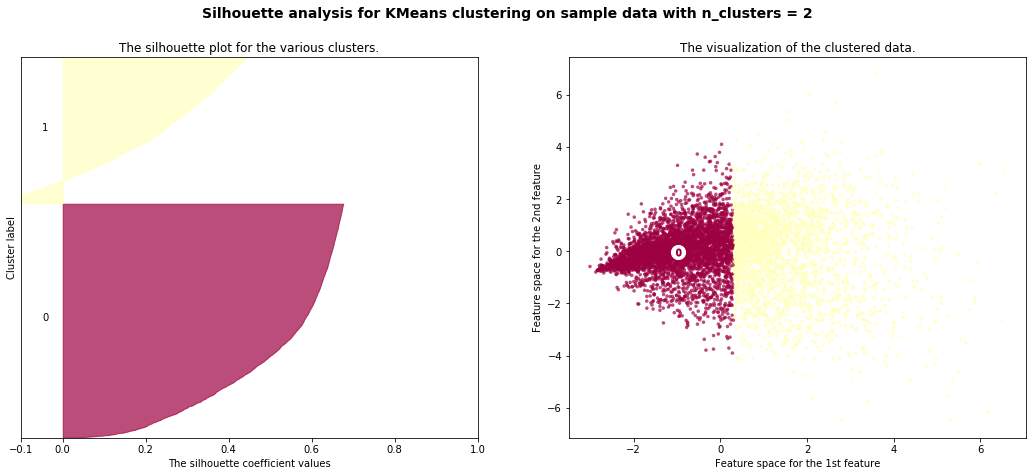

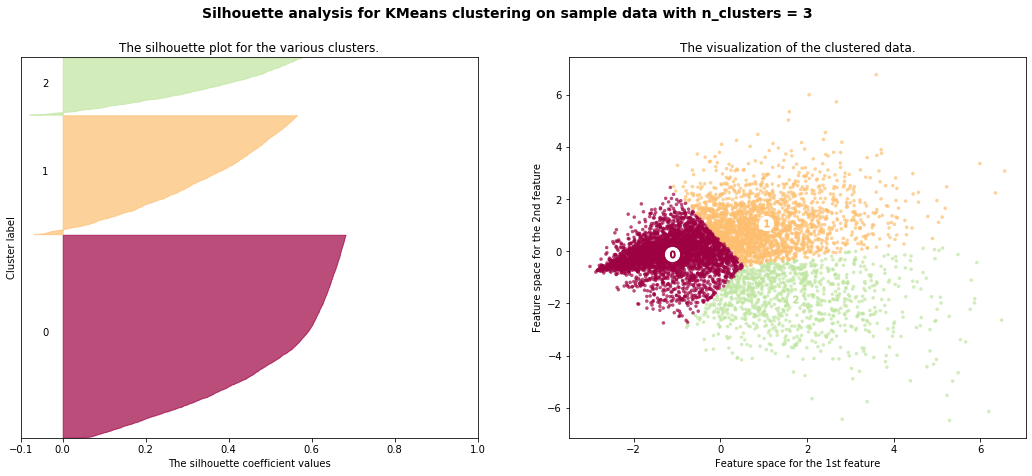

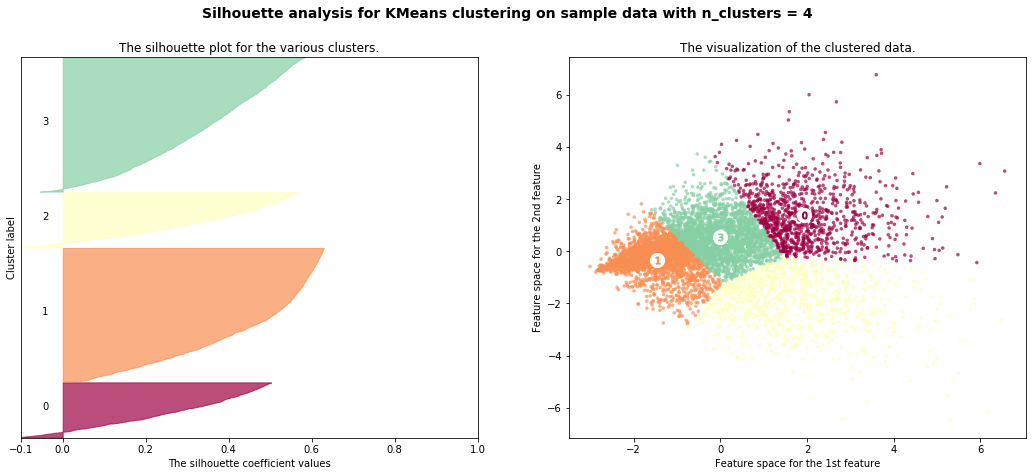

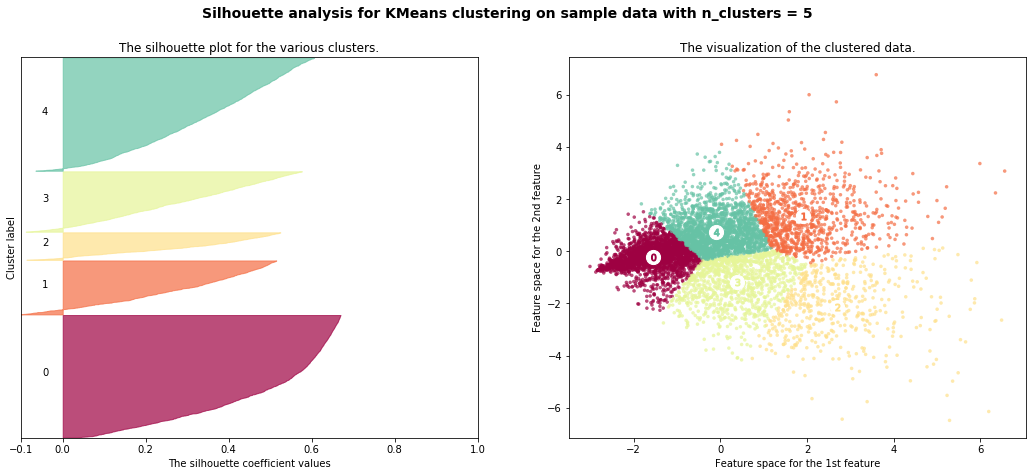

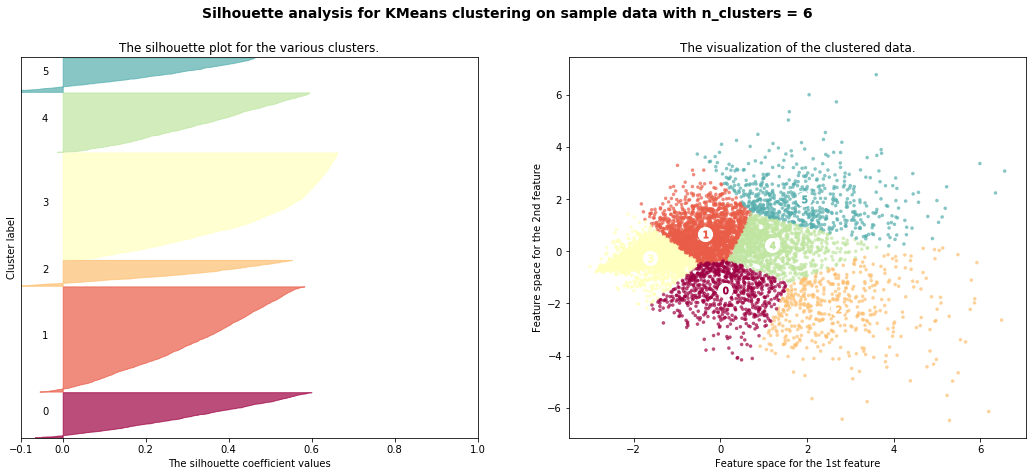

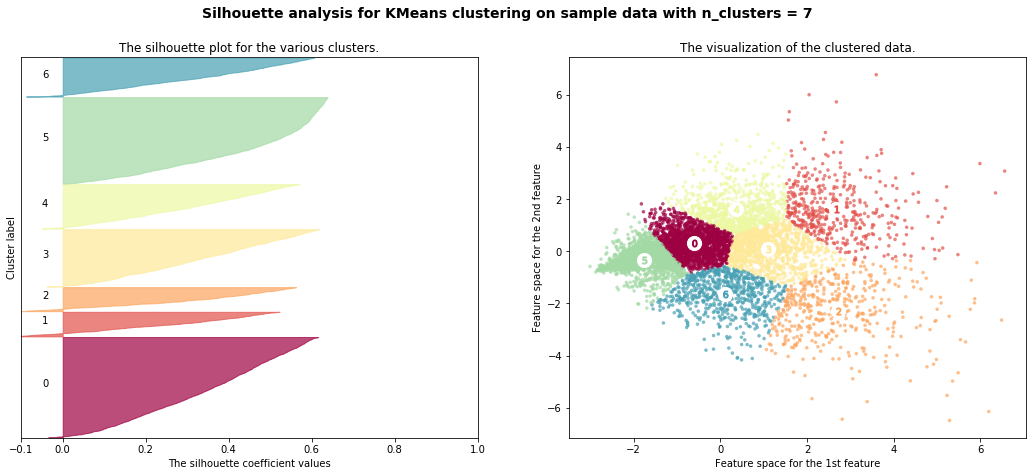

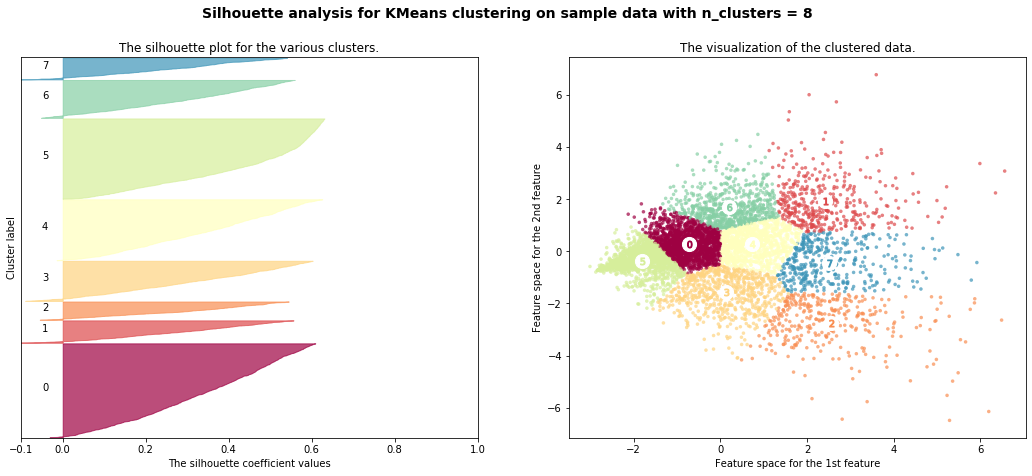

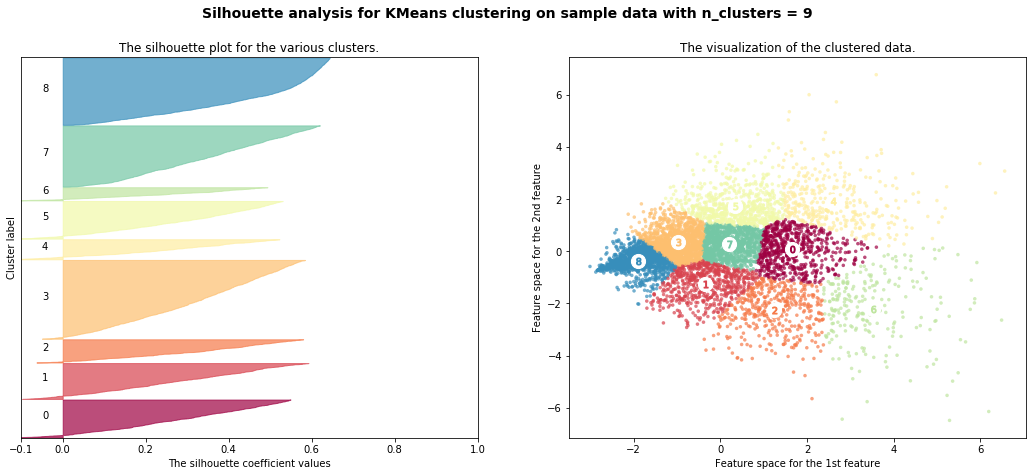

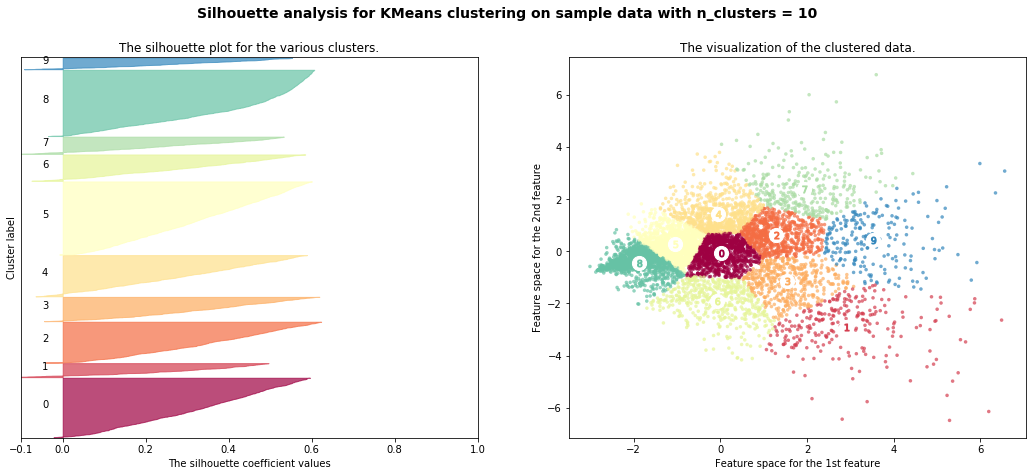

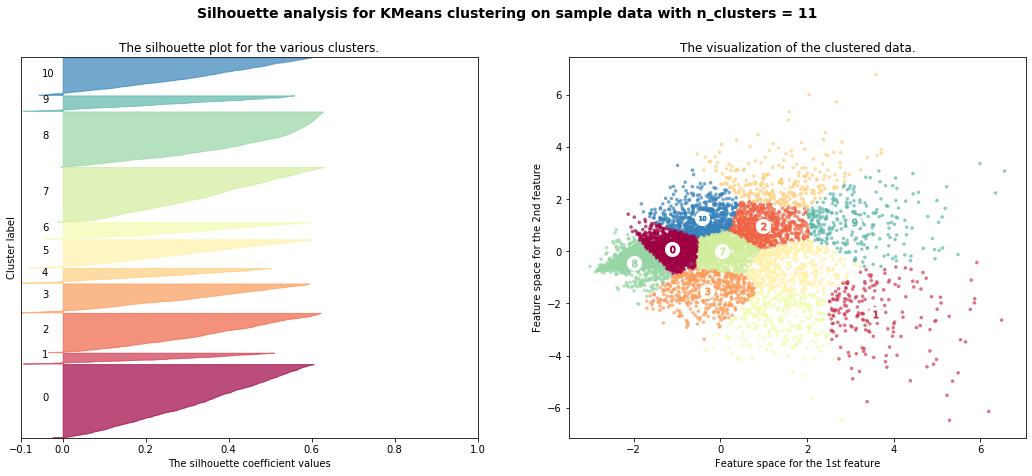

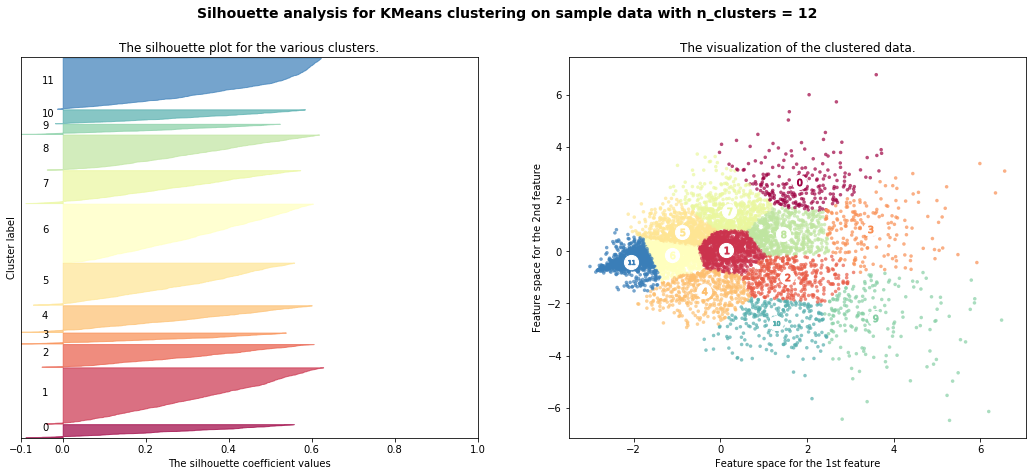

In [125]:
range_n_clusters = range(2, 13)
silhouette_scores_cv = np.empty(shape=11)

for idx, n_clusters in enumerate(range_n_clusters):
    fig, axs = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    score = make_silhouette_plot(axs, X = pca_X_cv, n_clusters=n_clusters)
    silhouette_scores_cv[idx] = score
    
    print(n_clusters)
    print(score)

Text(0, 0.5, 'silhouette score')

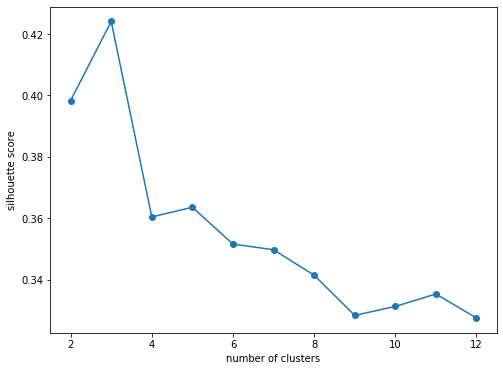

In [126]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(range_n_clusters, silhouette_scores_cv, 'o-')
ax.set_xlabel("number of clusters")
ax.set_ylabel("silhouette score")


2
0.3493918286915047
3
0.3536475274852246
4
0.3569797089878999
5
0.3567342604879751
6
0.35391225216154265
7
0.33414856593946557
8
0.3224914332725206
9
0.32792162779945383
10
0.3276234001935016
11
0.32508372009301234
12
0.3226328441098176


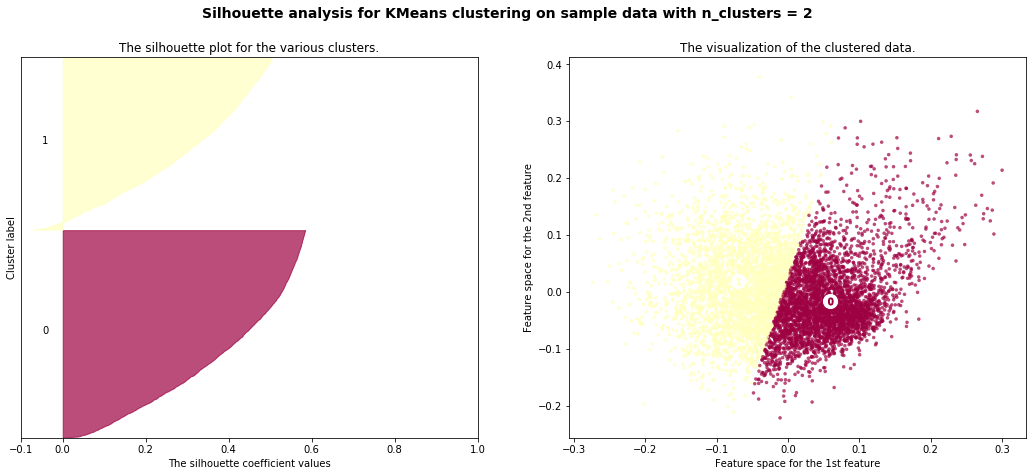

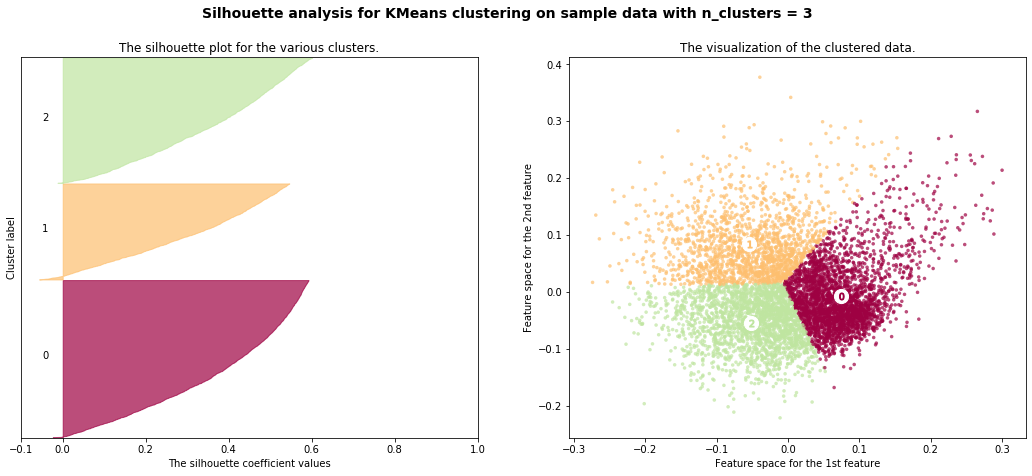

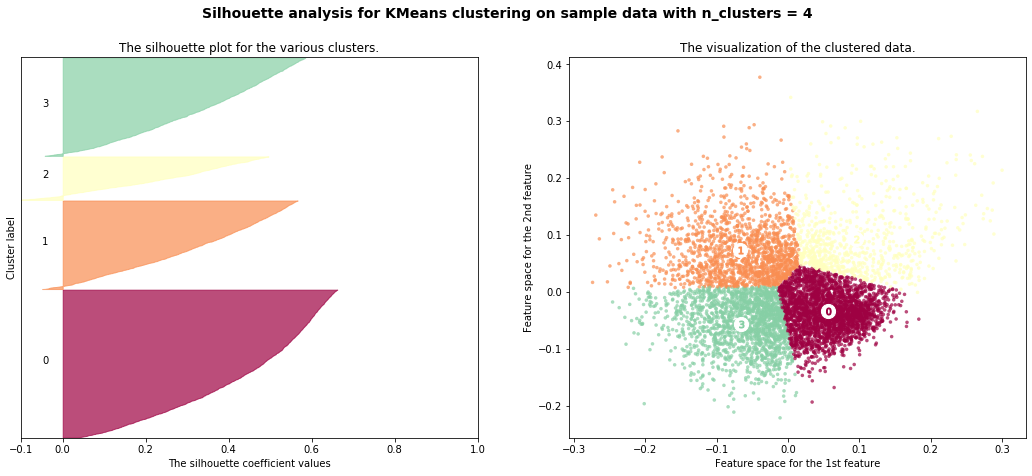

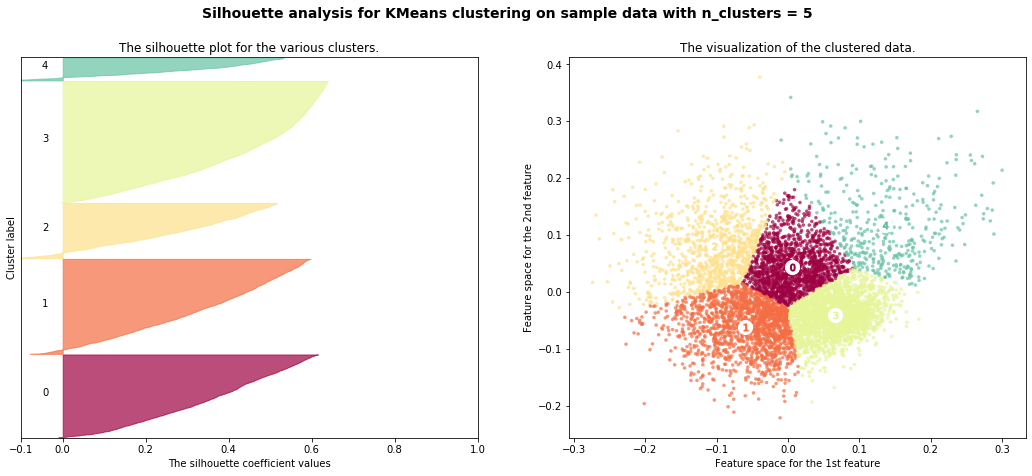

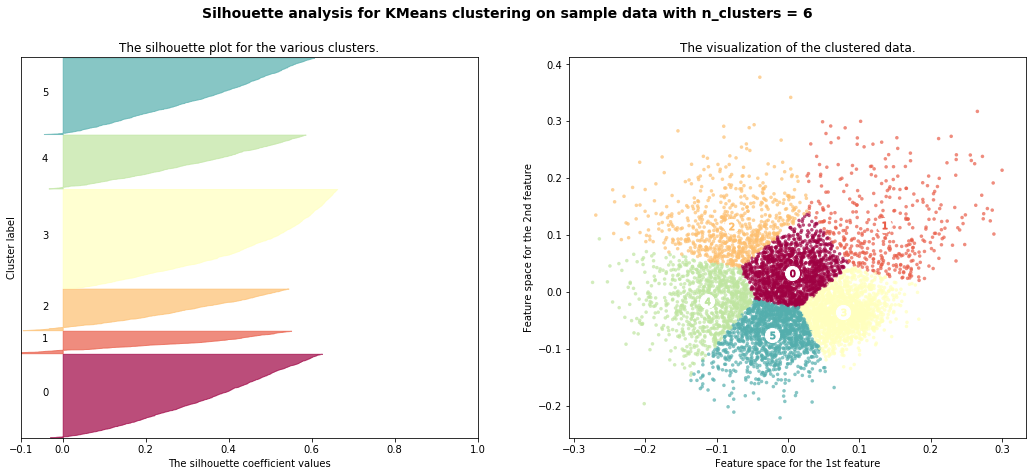

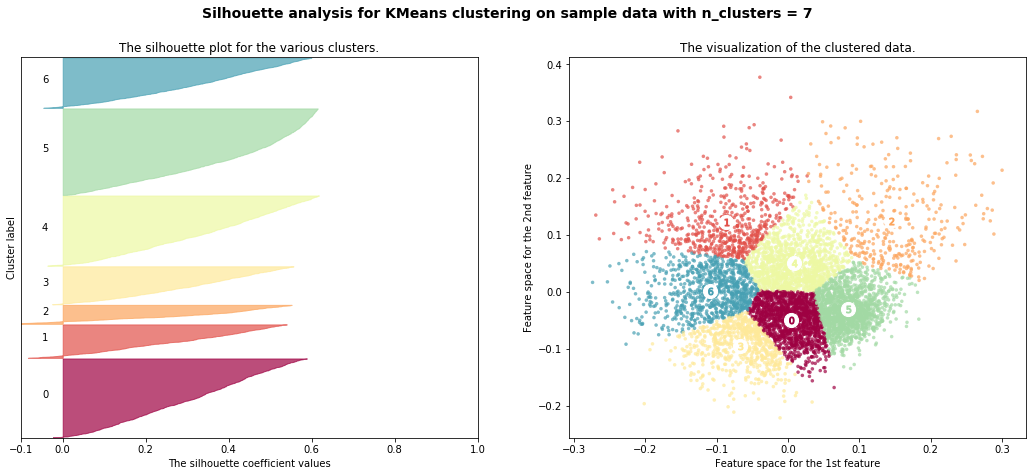

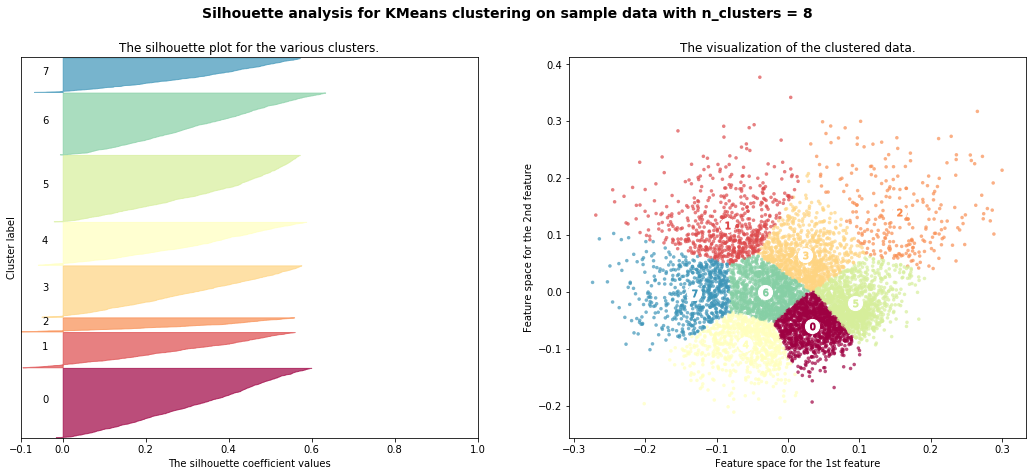

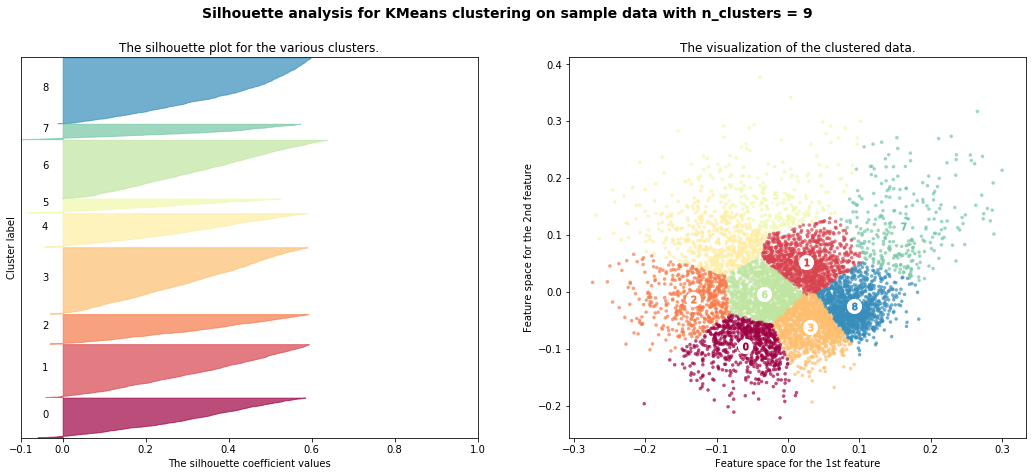

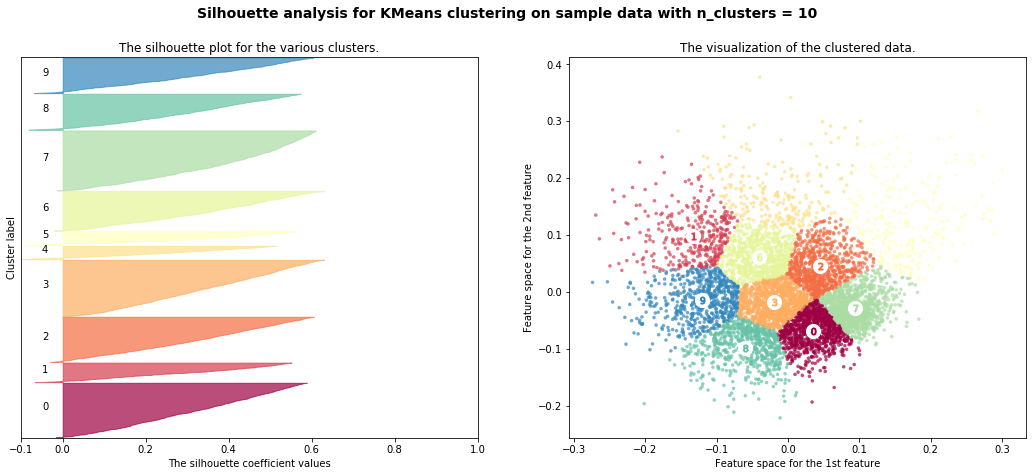

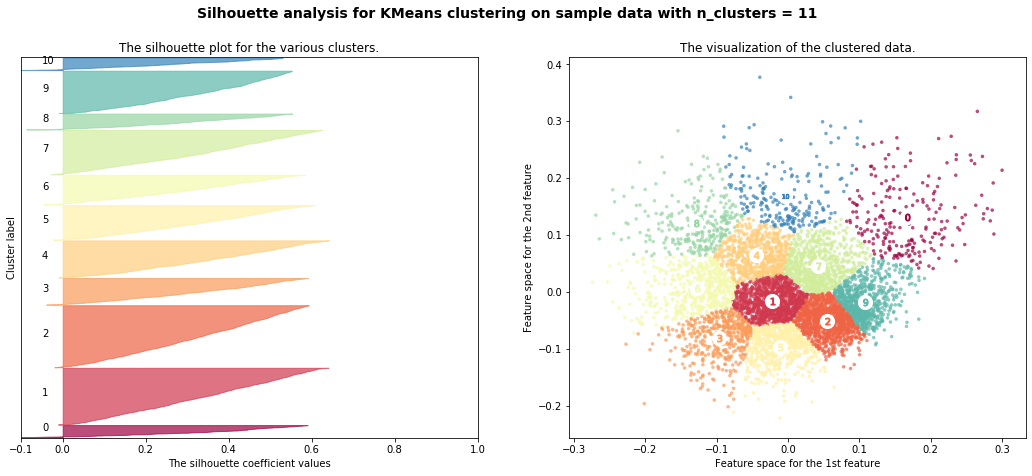

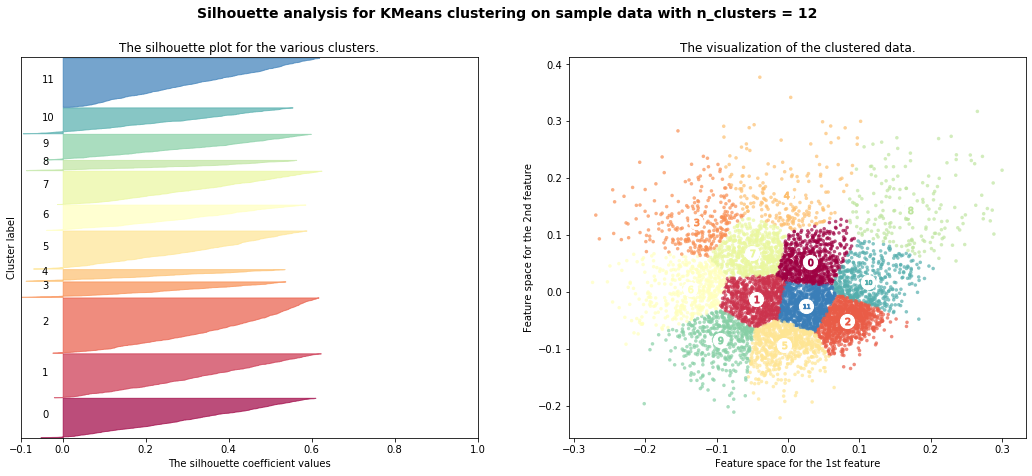

In [268]:
range_n_clusters = range(2, 13)
silhouette_scores = np.empty(shape=11)

for idx, n_clusters in enumerate(range_n_clusters):
    fig, axs = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    score = make_silhouette_plot(axs, X = pca_X_tv, n_clusters=n_clusters)
    silhouette_scores[idx] = score
    
    print(n_clusters)
    print(score)

Text(0, 0.5, 'silhouette score')

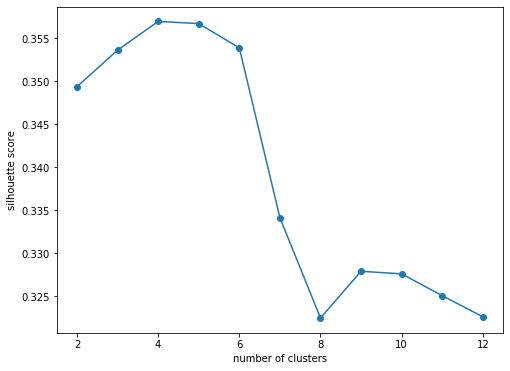

In [202]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(range_n_clusters, silhouette_scores, 'o-')
ax.set_xlabel("number of clusters")
ax.set_ylabel("silhouette score")


In [504]:
nclusters = 4

In [505]:
km = KMeans(random_state=42, n_clusters=nclusters, n_jobs=-1)
km.fit(pca_X_tv)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=-1, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

In [506]:
original_space_centroids = pca_tv.inverse_transform(km.cluster_centers_)
order_centroids = original_space_centroids.argsort()[:, ::-1]

In [507]:
terms = stv.get_feature_names()
for i in range(nclusters):
    print("Cluster %d:" % i, end='')
    for ind in order_centroids[i, :50]:
        print(' %s' % terms[ind], end='')
    print('\n')

Cluster 0: friend peopl would like feel think know want person make tell someon work ask gift help call year mani need talk someth look take problem date thing school find good could pleas love invit give also thank famili even start howev home never relationship come keep wed parent much rude

Cluster 1: husband daughter mother famili want children year parent would feel father wife live sister marri know love child help marriag tell think need like home life relationship move make brother kid never babi told divorc talk take work thing togeth come stay care wed month say hous visit also give

Cluster 2: gift daughter invit famili wed mother would husband sister children parent parti birthday child thank card home ask babi think send money brother give guest take attend peopl like dinner want receiv come father christma food visit make live rude shower holiday also hous celebr wife call expect someth know

Cluster 3: want friend feel year love know relationship husband like help would

In [508]:
print("Silhouette Coefficient: %0.3f"
      % silhouette_score(pca_X_tv, km.labels_, sample_size=1000))

print()

Silhouette Coefficient: 0.361



In [510]:
nclusters = 4

In [511]:
km = KMeans(random_state=42, n_clusters=nclusters, n_jobs=-1)
km.fit(pca_X_cv)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=-1, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

In [512]:
original_space_centroids = pca_cv.inverse_transform(km.cluster_centers_)
order_centroids = original_space_centroids.argsort()[:, ::-1]

In [513]:
terms = scv.get_feature_names()
for i in range(nclusters):
    print("Cluster %d:" % i, end='')
    for ind in order_centroids[i, :50]:
        print(' %s' % terms[ind], end='')
    print('\n')

Cluster 0: want feel friend would know like year love famili relationship make think tell help live life parent need mother talk thing peopl never work marri children daughter date togeth move person wife also told take could home father husband someon good start much problem find boyfriend school even say come

Cluster 1: would think peopl like friend husband know make tell ask help person work daughter take year famili want feel need someon wife problem gift pleas call someth also talk mani could mother home children parent give howev thing look recent live even good find keep told come tri never right

Cluster 2: husband want year famili would feel know marri children mother help live love daughter marriag think need make home tell like wife work take father sister life child never parent told problem talk could say thing come move also togeth kid tri hous relationship stay ask visit month much care

Cluster 3: want friend would feel know like year think make tell famili help peopl 

In [514]:
print("Silhouette Coefficient: %0.3f"
      % silhouette_score(pca_X_cv, km.labels_, sample_size=1000))

print()

Silhouette Coefficient: 0.361



In [525]:
llabels = pd.concat([y, pd.Series(km.labels_, index=y.index)], axis=1)

In [526]:
mlb = MultiLabelBinarizer()

In [527]:
n = 4
for i in range(n):
    pred = llabels.loc[llabels[0] == i, 'categories'].fillna('list()').apply(eval)

    res = pd.DataFrame(mlb.fit_transform(pred),
                       columns=mlb.classes_,
                       index=pred.index)

    print(f'topic {i}:')
    print(f'{res.sum(axis=0).sort_values(ascending=False)[:5]}')
    print()

topic 0:
Family & Parenting     462
Love & Dating          366
Marriage & Divorce     244
Friends & Neighbors    191
Teens                  119
dtype: int64

topic 1:
Etiquette & Ethics    862
Family & Parenting    744
Health & Safety       376
Marriage & Divorce    327
Money                 317
dtype: int64

topic 2:
Marriage & Divorce    577
Family & Parenting    514
Money                 153
Health & Safety       132
Sex & Gender           99
dtype: int64

topic 3:
Family & Parenting     1010
Love & Dating           594
Friends & Neighbors     460
Marriage & Divorce      368
Etiquette & Ethics      356
dtype: int64



In [285]:
no_cat = qadf[qadf['categories'].isna()]
X_nc = no_cat['qa']

In [287]:
tfidf_nc = stv.transform(X_nc)

In [290]:
pca_nc = pca_tv.transform(tfidf_nc.toarray())

In [297]:
cat_labels = km.predict(pca_X_tv)

In [293]:
unseen_labels = km.predict(pca_nc)

In [299]:
unseen_labels

array([1, 0, 0, ..., 2, 1, 1], dtype=int32)

In [324]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.metrics import balanced_accuracy_score

In [410]:
X_train, X_test, y_train, y_test = train_test_split(pca_X_tv, cat_labels, test_size=0.2, random_state=42)
# X_train, X_test, y_train, y_test = train_test_split(tfidf_df_train, cat_labels, test_size=0.2, random_state=42)

In [411]:
kf = RepeatedStratifiedKFold(random_state=42)

In [412]:
logreg = LogisticRegression(max_iter=1000000)
rf = RandomForestClassifier(random_state=42)

In [402]:
logreg_scores = cross_val_score(logreg, X_train, y_train, cv=kf, scoring='roc_auc_ovr', n_jobs=-1)

In [413]:
rf_scores = cross_val_score(rf, X_train, y_train, cv=kf, scoring='roc_auc_ovr', n_jobs=-1)

In [404]:
np.mean(logreg_scores)

0.9917985734735013

In [405]:
np.mean(rf_scores)

0.9561050681784785

In [406]:
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [407]:
balanced_accuracy_score(y_test, logreg.predict(X_test))

0.9218201091441741

In [414]:
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [415]:
balanced_accuracy_score(y_test, rf.predict(X_test))

0.992841685939561

In [416]:
rf.predict_proba(X_test)

array([[0.99, 0.01, 0.  ],
       [0.87, 0.01, 0.12],
       [0.  , 1.  , 0.  ],
       ...,
       [1.  , 0.  , 0.  ],
       [0.  , 0.  , 1.  ],
       [1.  , 0.  , 0.  ]])

In [328]:
rf.fit(pca_X_tv, cat_labels)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [330]:
balanced_accuracy_score(unseen_labels, rf.predict(pca_nc))

0.9932178717459811

In [499]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
        print()
    print()

In [148]:
from sklearn.decomposition import NMF, LatentDirichletAllocation

In [484]:
n_components= 4
n_top_words = 50

In [498]:
nmf = NMF(n_components=n_components, random_state=42,
          alpha=.1, l1_ratio=.5).fit(tfidf_df)

tfidf_feature_names = stv.get_feature_names()
print_top_words(nmf, tfidf_feature_names, n_top_words)

(4, 7364)
Topic #0: want feel would know like famili love year mother help think tell live parent relationship make wife children work need daughter life talk thing peopl father never move take problem home boyfriend could child togeth find also much told sister someon person start date tri someth care woman pleas ask

Topic #1: gift wed invit daughter birthday card parti send thank shower guest attend would give christma receiv note celebr famili bride holiday etiquett money babi expect sent coupl plan dinner sister host present fianc gave ask niec includ marri given appropri return occas engag item nice someth nephew announc special mother

Topic #2: friend friendship invit best call date person parti peopl school close like feel know dinner social ask good rude tell coupl talk someon girl hang phone group even think differ mine realli meet polit guest facebook would male make girlfriend hurt interest stop lunch said still text high wrong join

Topic #3: husband marriag marri year di

In [75]:
# nmf = NMF(n_components=n_components, random_state=42,
#           beta_loss='kullback-leibler', solver='mu', max_iter=1000, alpha=.1,
#           l1_ratio=.5).fit(tfidf_df)

# tfidf_feature_names = stv.get_feature_names()
# print_top_words(nmf, tfidf_feature_names, n_top_words)

In [497]:
lda_cv = LatentDirichletAllocation(n_components=n_components, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=42)

lda_tf = lda_cv.fit_transform(count_df)
tf_feature_names = scv.get_feature_names()
print_top_words(lda_cv, tf_feature_names, n_top_words)

(4, 2000)
Topic #0: help parent school need know children want feel work talk child make like problem daughter take abus also would girl peopl find think tell live life high doctor start pleas colleg mother health go care could year support becom tri thing get famili medic stop someth adult keep right happen

Topic #1: peopl would think like person ask work make look call thank gift someon want know tell wear someth friend mani phone feel busi neighbor rude send pleas worker could good also dress woman letter howev reader said receiv problem walk convers keep embarrass take birthday question use husband talk suggest

Topic #2: husband home would famili want invit hous live friend take feel daughter money make like visit wed dinner wife think come mother work food need stay parti ask year help plan spend room even gift children guest know enjoy give week attend move retir coupl problem everi much leav could

Topic #3: year want feel friend would know husband love relationship famili lik

In [468]:
import pyLDAvis
import pyLDAvis.sklearn

In [469]:
pyLDAvis.enable_notebook()

In [522]:
pyLDAvis.sklearn.prepare(lda_cv, count_df, scv)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.039935  0.003671       1        1  42.503192
0     -0.102037 -0.068222       2        1  22.189684
2      0.006345  0.120431       3        1  18.759869
1      0.135627 -0.055880       4        1  16.547255, topic_info=              Term         Freq        Total Category  logprob  loglift
1553        school  1176.000000  1176.000000  Default  30.0000  30.0000
880           home  1838.000000  1838.000000  Default  29.0000  29.0000
1467  relationship  2010.000000  2010.000000  Default  28.0000  28.0000
977          invit   946.000000   946.000000  Default  27.0000  27.0000
868           help  2905.000000  2905.000000  Default  26.0000  26.0000
...            ...          ...          ...      ...      ...      ...
754         friend   411.203034  3769.218777   Topic4  -5.2066  -0.4166
693           feel   329.050851  4392.868391   Topic4  -5.4295  -0.7926
1325         pleas   294.160480  1446.549400   Topic4  -5.5416   0.2061
415          could   287.262955  1653.947131   Topic4  -5.5653   0.0484
794           good   284.486232  1414.354135   Topic4  -5.5750   0.1952

[342 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
5         1  0.070767    abus
5         2  0.928598    abus
27        1  0.015634  addict
27        2  0.979757  addict
33        1  0.934885   adopt
...     ...       ...     ...
1983      4  0.163696   would
1992      1  0.770065    year
1992      2  0.107782    year
1992      3  0.104019    year
1992      4  0.018277    year

[726 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 3, 2])